# TODO

* test with `rerun_analysis = True`
* test with `rerun_analysis = False`
* Write intro
* Briefly describe each section under section headers


# Introduction

TODO

# Set Up

## Libraries and paths

In [227]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from tqdm import tqdm
import cdapsutil
import ndex2
from scipy.stats import hypergeom
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

In [228]:
# Set up directory paths. Defaults to the Data/ and Figures/ folders within the repository.
cwd = os.path.dirname(os.getcwd())
DATADIR = os.path.join(cwd, "Data/")
#FIGDIR = os.path.join(cwd, "Figures/rerun_")
FIGDIR = os.path.join(cwd, "Figures/")

In [ ]:
rerun_analysis = False

In [93]:
sys.path.append(cwd)
from analysis_functions import *

## Input Data

In [229]:
# load data, contains original subgraphs
data = pd.read_csv(DATADIR + "outputs/rat_human_BMI_all_NPS.tsv", sep = "\t", index_col=0)
data.head()

,NPS_r,NPS_h,NPS_hr
gene,,,
A1BG,0.125314,-0.488576,-0.061226
A1CF,2.540447,2.186042,5.553524
A2M,0.651845,-0.581848,-0.379275
A2ML1,-1.315517,-1.108608,1.458393
A3GALT2,-0.546107,-0.243477,0.132964


In [95]:
# load seed genes
seed_bin_human_BMI = pd.read_csv(DATADIR+"inputs/human_BMI_all_seed_genes.txt", header=None)[0].tolist()
print("Number of human BMI seeds:", len(seed_bin_human_BMI))

seed_bin_rat_BMI=pd.read_csv(DATADIR+'inputs/ratBMI_seed_relaxed.txt',sep='\t')['0'].tolist()
print("Number of rat BMI seeds:", len(seed_bin_rat_BMI))

Number of human BMI seeds: 1958
Number of rat BMI seeds: 295


In [96]:
# classify each genes based on seed gene status
data = data.assign(rat_seed=[1 if gene in seed_bin_rat_BMI else 0 for gene in data.index])
data = data.assign(human_seed=[1 if gene in seed_bin_human_BMI else 0 for gene in data.index])

# Defining species specific Networks

## Distributions of the species NPS

To determine appropriate thresholds for each species we examine the distribution of network proximity scores (NPS). 

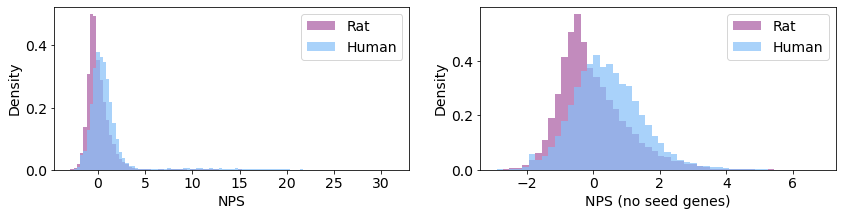

In [97]:
matplotlib.rcParams.update({'font.size': 14})
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 3))
_, bins, _ = ax1.hist(data.NPS_r, bins=100, alpha=0.7, density=True, label="Rat", color="#a95aa1")
_ = ax1.hist(data.NPS_h, bins=bins, alpha=0.7, density=True, label="Human", color="#85c0f9")
ax1.set_ylabel("Density")
ax1.set_xlabel("NPS")
ax1.legend()

_, bins, _ = ax2.hist(data[data.rat_seed==0].NPS_r, bins=50, alpha=0.7, density=True, label="Rat", color="#a95aa1")
_ = ax2.hist(data[data.human_seed==0].NPS_h, bins=bins, alpha=0.7, density=True, label="Human", color="#85c0f9")
ax2.set_ylabel("Density")
ax2.set_xlabel("NPS (no seed genes)")
ax2.legend()


In [98]:
data.loc[:, ("NPS_r", "NPS_h")].describe()

,NPS_r,NPS_h
count,18820.000000,18820.000000
mean,0.166117,1.064944
std,1.819963,3.034380
min,-2.908312,-3.953688
25%,-0.699091,-0.227384
50%,-0.220273,0.450951
75%,0.566990,1.240185
max,31.286290,34.273300


In [99]:
data[data.rat_seed==0].NPS_r.describe(percentiles=[0.5, 0.75, 0.8, 0.85, 0.9, 0.95])

count    18525.000000
mean        -0.013611
std          1.030633
min         -2.908312
50%         -0.237388
75%          0.518693
80%          0.729556
85%          1.005072
90%          1.354651
95%          1.952714
max          6.798332
Name: NPS_r, dtype: float64

In [100]:
data[data.human_seed==0].NPS_h.describe(percentiles=[0.5, 0.75, 0.8, 0.85, 0.9, 0.95])

count    16862.000000
mean         0.425921
std          1.047217
min         -3.953688
50%          0.348532
75%          1.069361
80%          1.240472
85%          1.464345
90%          1.742707
95%          2.219446
max          6.620334
Name: NPS_h, dtype: float64

## Set thresholds

TODO

In [230]:
# set thresholds:
conserved = {"rat":1, "human":1, "combo":3}
rat_only = {"rat":1, "human":0.5, "combo":-2}
human_only = {"rat":0, "human":1.5, "combo":-4}

Original SubGraph designations come from thresholds:  
`conserved = {"rat":1, "human":1, "combo":3}`  
`rat_only = {"rat":1, "human":0.5, "combo":-1.5}`  
`human_only = {"rat":0.5, "human":1, "combo":-1.5}`

**Combo scores are used as follows:**  

  
Conserved: $z_{rat}\bullet z_{human} > combo$  
  
Rat Only: $z_{rat}\bullet (z_{human} - 1) < combo$  
  
Human Only: $(z_{rat}-1)\bullet z_{human} < combo$

## Identify subgraphs

In [102]:
def assign_sub_graph(data, rat_th=None, human_th=None, combo_th=None, th_dict=None, name="conserved"):
    if th_dict is not None:
        rat_th = th_dict["rat"]
        combo_th = th_dict["combo"]
        human_th = th_dict["human"]
    if "subgraph" not in data.columns:
        data = data.assign(subgraph="PCNet")
    if name == "rat":
        data.loc[((data.NPS_r > rat_th) & (data.NPS_h < human_th) & (data.NPS_r * (data.NPS_h - 1) < combo_th)), 
                 ("subgraph")] = "Rat-Only"
    elif name == "human":
        data.loc[((data.NPS_r < rat_th) & (data.NPS_h > human_th) & ((data.NPS_r - 1)*(data.NPS_h) < combo_th)), 
                 ("subgraph")] = "Human-Only"
    else:
        data.loc[((data.NPS_r > rat_th) & (data.NPS_h > human_th) & (data.NPS_hr > combo_th)), ("subgraph")] = "Conserved"
    return data

In [103]:
# classify each gene based on membership to sub networks
data = assign_sub_graph(data, th_dict = conserved, name="conserved")
data = assign_sub_graph(data, th_dict = rat_only, name="rat")
data = assign_sub_graph(data, th_dict = human_only, name="human")

In [104]:
data.value_counts("subgraph", dropna=False)

subgraph
PCNet         16550
Human-Only      925
Rat-Only        688
Conserved       657
dtype: int64

In [105]:
# export the data
data.to_csv(DATADIR + "outputs/rat_only_human_only_networks.tsv", sep="\t")

## Visualize the species specific networks

In [107]:
def plot_species_nps(data, subgraph, th_dict=None, ax=None, legend=None):
    x_points = [(i+0.0001)/10 for i in range(-50,250)]
    if subgraph == "conserved":
        cmap = {"Conserved": "#F5793A", **{k:"grey" for k in ["Rat-Only", "PCNet", "Human-Only"]}}
        combo_line = [th_dict["combo"]/x for x in x_points if x > th_dict["combo"]/25]
        ax.plot([x for x in x_points if x > th_dict["combo"]/25], combo_line, color="#f5793a")
        ax.text(x=10, y=30, s="$NPS_r > "+str(th_dict["rat"])+"$", color="#a95aa1")
        ax.text(x=10, y=26, s="$NPS_h > "+str(th_dict["human"])+"$", color="#85c0f9")
        ax.text(x=10, y=22, s="$NPS_{hr} > "+str(th_dict["combo"])+"$", color="#f5793a")
    elif subgraph == "rat":
        cmap = {"Rat-Only": "#a95aa1", **{k:"grey" for k in ["Conserved", "PCNet", "Human-Only"]}}
        combo_line = [th_dict["combo"]/(x-1) for x in x_points if x < 1 + th_dict["combo"]/25]
        ax.plot([x for x in x_points if x < 1 + th_dict["combo"]/25], combo_line, color="#f5793a")
        ax.text(x=10, y=30, s="$NPS_r > "+str(th_dict["rat"])+"$", color="#a95aa1")
        ax.text(x=10, y=26, s="$NPS_h < "+str(th_dict["human"])+"$", color="#85c0f9")
        ax.text(x=10, y=22, s="$NPS_r(NPS_h-1) < "+str(th_dict["combo"])+"$", color="#f5793a")
    elif subgraph == "human":
        cmap = {"Human-Only": "#85c0f9", **{k:"grey" for k in ["Rat-Only", "PCNet", "Conserved"]}}
        combo_line = [1 + th_dict["combo"]/x for x in x_points if x > th_dict["combo"]/-6]
        ax.plot([x for x in x_points if x > th_dict["combo"]/-6], combo_line, color="#f5793a")
        ax.text(x=10, y=30, s="$NPS_r < "+str(th_dict["rat"])+"$", color="#a95aa1")
        ax.text(x=10, y=26, s="$NPS_h > "+str(th_dict["human"])+"$", color="#85c0f9")
        ax.text(x=10, y=22, s="$NPS_h(NPS_r-1) < "+str(th_dict["combo"])+"$", color="#f5793a")
    else:
        cmap = {"Conserved": "#F5793A","Rat-Only": "#a95aa1", "Human-Only": "#85c0f9", "PCNet":"grey" }
    
    sns.scatterplot(data=data, x="NPS_h", y="NPS_r", hue="subgraph", palette=cmap, s=5, ax=ax, markers=True, alpha=0.8,
                legend=legend)
    if th_dict is not None:
        ax.hlines(y=th_dict["rat"], xmin=-5, xmax=25, color="#a95aa1", alpha=1, zorder=4)
        ax.vlines(x=th_dict["human"], ymin=-5, ymax=25, color="#85c0f9", alpha=1, zorder=3)
    ax.set_ylabel("NPS$_r$")
    ax.set_xlabel("NPS$_h$")
    ax.spines['left'].set(position=('data', 0.0), zorder=2)
    ax.spines['bottom'].set(position=('data', 0.0), zorder=2)
    ax.spines['top'].set_position(('data', 0.0))
    ax.spines['right'].set_position(('data', 0.0))

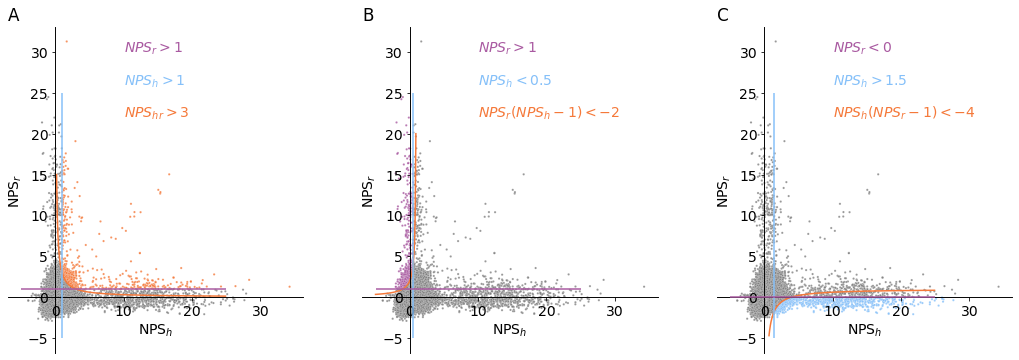

In [108]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
plot_species_nps(data, "conserved", conserved, ax1)
plot_species_nps(data, "rat", rat_only, ax2)
plot_species_nps(data, "human", human_only, ax3)
ax1.set_title("A", loc="left")
ax2.set_title("B", loc="left")
ax3.set_title("C", loc="left")
plt.savefig(FIGDIR + "definition_of_networks.png", dpi=400, bbox_inches="tight")

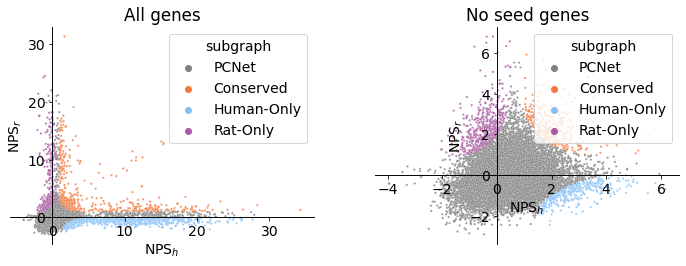

In [109]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
plot_species_nps(data, "all", ax=ax1, legend="brief")
plot_species_nps(data[data.rat_seed+data.human_seed==0], "all", ax=ax2, legend="brief")
_ = ax2.set_title("No seed genes")
_ = ax1.set_title("All genes")

## Assess seed gene fractions

In [110]:
data = data.assign(overlapping_seeds=1*(data.rat_seed + data.human_seed==2))
data.head()

,NPS_r,NPS_h,NPS_hr,rat_seed,human_seed,subgraph,overlapping_seeds
gene,,,,,,,
A1BG,0.125314,-0.488576,-0.061226,0,0,PCNet,0
A1CF,2.540447,2.186042,5.553524,0,0,Conserved,0
A2M,0.651845,-0.581848,-0.379275,0,0,PCNet,0
A2ML1,-1.315517,-1.108608,1.458393,0,0,PCNet,0
A3GALT2,-0.546107,-0.243477,0.132964,0,1,PCNet,0


In [111]:
subgraph_stats = data.groupby("subgraph").sum().loc[:, ("rat_seed", "human_seed", "overlapping_seeds")]

In [112]:
subgraph_stats = subgraph_stats.join(data.groupby("subgraph").count().loc[:, "NPS_r"])
subgraph_stats = subgraph_stats.rename(columns={"NPS_r":"count"})
subgraph_stats["Network"] = subgraph_stats["count"].values - subgraph_stats.loc[:,("rat_seed", "human_seed", "overlapping_seeds")].sum(axis=1).values
subgraph_stats.drop(columns=["count"], inplace=True)
subgraph_stats = subgraph_stats.loc[:,( "human_seed", "overlapping_seeds","rat_seed", "Network") ]

(0.0, 1300.0)

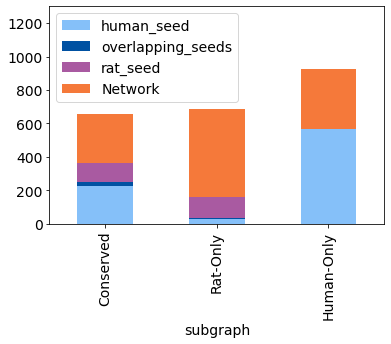

In [113]:
subgraph_stats.loc[["Conserved", "Rat-Only", "Human-Only"]].plot(kind="bar", stacked=True, color=["#85c0f9", "#0051a2",
                                                                                                 "#a95aa1", "#F5793a"])
plt.ylim((0, 1300))

# Tissue enrichments of conserved & species specific networks

TODO
Link to where tissue enrichment done

Mouse: https://tissueenrich.gdcb.iastate.edu/

In [ ]:
def to_mouse_genes(gene_list, mgi_df):
    orthos = mgi_df.loc[mgi_df.human_ortholog.isin(gene_list), ("gene_name")].unique()
    return orthos

## Get gene lists for each subnetwork

In [114]:
# create lists of genes within the three subgraphs
with open(DATADIR + "outputs/conserved_subgraph_genes.txt", 'w') as fp:
    fp.write('\n'.join(data.loc[data.subgraph=="Conserved"].index.values))
with open(DATADIR + "outputs/rat_subgraph_genes.txt", 'w') as fp:
    fp.write('\n'.join(data.loc[data.subgraph=="Rat-Only"].index.values))
with open(DATADIR + "outputs/human_subgraph_genes.txt", 'w') as fp:
    fp.write('\n'.join(data.loc[data.subgraph=="Human-Only"].index.values))

In [115]:
mgi_df = load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt',
                                         map_using="mgi", update=False, data_loc=DATADIR+"Reference/")

In [116]:
# create subgraph lists with mouse orthologs
with open(DATADIR + "outputs/conserved_subgraph_genes_mouse.txt", 'w') as fp:
    fp.write('\n'.join(to_mouse_genes(data.loc[data.subgraph=="Conserved"].index.values, mgi_df)))
with open(DATADIR + "outputs/rat_subgraph_genes_mouse.txt", 'w') as fp:
    fp.write('\n'.join(to_mouse_genes(data.loc[data.subgraph=="Rat-Only"].index.values, mgi_df)))
with open(DATADIR + "outputs/human_subgraph_genes_mouse.txt", 'w') as fp:
    fp.write('\n'.join(to_mouse_genes(data.loc[data.subgraph=="Human-Only"].index.values, mgi_df)))

## Import tissue enrichment results

In [123]:
# read in the results of tissue enrichments in human tissue
human_te_files = {"C":DATADIR+"outputs/C_TSEA.txt", "R":DATADIR+"outputs/R_TSEA.txt", "H":DATADIR+"outputs/H_TSEA.txt"}
human_te = {}
for subgraph in human_te_files:
    tsea = pd.read_csv(human_te_files[subgraph], index_col=0, sep="\t")
    tsea[subgraph+"_FDR"] = tsea["0.05"].apply(lambda x: -1 * np.log10(float(x.split(" ")[2])))
    human_te[subgraph] = tsea.loc[:, (subgraph+"_FDR")]
human_te = pd.DataFrame.from_dict(human_te)

In [136]:
fdrcorrection(10**(-1* tsea["-Log10PValue"]))[1]

array([2.00119881e-05, 9.73241233e-05, 1.87774864e-04, 5.84066597e-04,
       2.85877456e-01, 9.99214794e-01, 9.99214794e-01, 9.99214794e-01,
       9.99214794e-01, 9.99214794e-01, 9.99214794e-01, 9.99214794e-01,
       9.99214794e-01, 9.99214794e-01, 9.99214794e-01, 9.99214794e-01,
       9.99214794e-01])

In [140]:
# read in the results of tissue enrichments in mouse tissue
mouse_te_files = {"C":DATADIR+"outputs/C_TSEA_mouse_ENCODE.tsv", 
                  "R":DATADIR+"outputs/R_TSEA_mouse_ENCODE.tsv", 
                  "H":DATADIR+"outputs/H_TSEA_mouse_ENCODE.tsv"}
mouse_te = {}
for subgraph in mouse_te_files:
    tsea = pd.read_csv(mouse_te_files[subgraph], index_col=0, sep="\t")
    tsea[subgraph+"_FDR"] = -1* np.log10(fdrcorrection(10**(-1* tsea["-Log10PValue"]))[1])
    mouse_te[subgraph] = tsea.loc[:, (subgraph+"_FDR")]
mouse_te = pd.DataFrame.from_dict(mouse_te)

## Visualize tissue enrichment results

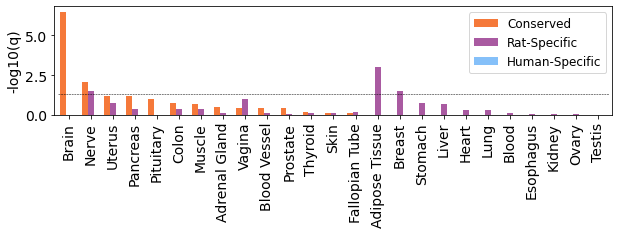

In [147]:
human_te.columns = ["Conserved", "Rat-Specific", "Human-Specific"]
human_te = human_te.sort_values(by=["Conserved", "Rat-Specific"], ascending=False)
fig, ax = plt.subplots(figsize=(10,2))
human_te.plot.bar(ax=ax, width=0.8, color=["#f5793a", "#a95aa1", "#85c0f9"], fontsize=14)
ax.set_ylabel("-log10(q)", fontsize=14)
ax.set_xlabel(None)
plt.hlines(-1 *np.log10(0.05),-0.5, 24.5, color="black", linestyle="dashed", linewidth=0.5)
plt.legend(fontsize=12)
plt.savefig(FIGDIR+"tissue_enrichment_human_GTEx.png", bbox_inches="tight", dpi=400)

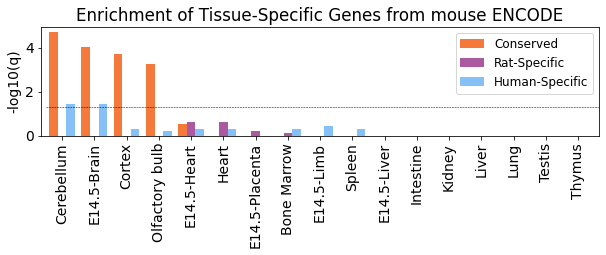

In [146]:
mouse_te.columns = ["Conserved", "Rat-Specific", "Human-Specific"]
mouse_te = mouse_te.sort_values(by=["Conserved", "Rat-Specific", "Human-Specific"], ascending=False)
fig, ax = plt.subplots(figsize=(10,2))
mouse_te.plot.bar(ax=ax, width=0.8, color=["#f5793a", "#a95aa1", "#85c0f9"], fontsize=14)
ax.set_ylabel("-log10(q)", fontsize=14)
ax.set_xlabel(None)
plt.hlines(-1 *np.log10(0.05),-0.5, 24.5, color="black", linestyle="dashed", linewidth=0.5)
plt.legend(fontsize=12)
plt.title("Enrichment of Tissue-Specific Genes from mouse ENCODE")
plt.savefig(FIGDIR+"tissue_enrichment_mouse_ENCODE.png", bbox_inches="tight", dpi=400)
#plt.savefig("/cellar/users/snwright/Data/Transfer/rat/triple_tissue_enrich.png", bbox_inches="tight", dpi=400)

# Hierarchical Community Detection of Species Specific Networks

## Define the combined network

To create a unified network for analyzing conserved, rat-specific and human-specific genes we take all genes with $NPS_r > 1$ **or** $NPS_h$ > 1.5 as per the thresholds defined above. 

In [148]:
pc_nodes, G = load_pcnet()

number of nodes:
18820

number of edges:
2693109


In [ ]:
# extract just the nodes meeting our criteria
G_all = G.subgraph(nodes=data.loc[(data.NPS_r > rat_only["rat"]) | (data.NPS_h > human_only["human"])].index)

In [158]:
G_all_cx = ndex2.create_nice_cx_from_networkx(G_all)
G_all_cx.set_name("Combined Rat-Human-Conserved BMI Network")

In [ ]:
# Save the network to NDEx
username = getpass("Username:")
passwd = getpass("Password:")
client = ndex2.client.Ndex2(username=username, password=passwd)
client.save_new_network(G_all_cx.to_cx(), visibility='PRIVATE')

In [277]:
print("Number of genes in combined network:", len(G_all.nodes))

Number of genes in combined network: 6025


## Perform hierarchical community detection

In [ ]:
if rerun_analysis:
    cd = cdapsutil.CommunityDetection()
    G_all_hier = cd.run_community_detection(G_all_cx, algorithm='hidefv1.1beta',arguments={'--maxres':str(10)})
    print('Hierarchy name: ' + str(G_all_hier.get_name()))
    print('# nodes: ' + str(len(G_all_hier.get_nodes())))
    print('# edges: ' + str(len(G_all_hier.get_edges())))
    all_hier_nx = G_all_hier.to_networkx(mode='default')
    nodes = all_hier_nx.nodes()
# print out interactome num nodes and edges for diagnostic purposes
    print('number of nodes:')
    print(len(all_hier_nx.nodes()))
    print('\nnumber of edges:')
    print(len(all_hier_nx.edges()))
# add node attributes to dataframe for easier access
    all_hier_df = pd.DataFrame.from_dict(dict(all_hier_nx.nodes(data=True)), orient='index')
    all_hier_df['system_ID']=all_hier_df.index.tolist()
# fix column types
    all_hier_df['CD_MemberList_Size']=[int(x) for x in all_hier_df['CD_MemberList_Size'].tolist()]
    all_hier_df['HiDeF_persistence']=[int(x) for x in all_hier_df['HiDeF_persistence'].tolist()]
    all_hier_df.set_index("name", inplace=True, drop=True)
    all_hier_df.index.name=None
else:
    # load the hierarchy data
    all_hier_df = pd.DataFrame(DATADIR + "outputs/species_combined_hierarchy_data.tsv", sep="\t")

## Annotate the hiearchy with GO terms

In [175]:

def filter_go_annotations(go_df, term_min=50, term_max=1000, p_th=1e-4, min_intersection=3):
    go_df = go_df[(go_df['term_size'] <= term_max) & (go_df['term_size'] >= term_min)]
    go_df = go_df[go_df['intersection_size'] >= min_intersection]
    go_df = go_df[go_df['p_value'] < p_th] # set a stringent pvalue threshold
    go_df['sum_PR'] = go_df['recall'] + go_df['precision']
    go_df = go_df.sort_values('sum_PR',ascending=False)
    return go_df

In [176]:
# Annotate with GO terms
# gprofiler annotation of clusters
if rerun_analysis:
    system_names = {}
    all_results = []
    for comm in tqdm(all_hier_df.index.tolist()):
        if isinstance(all_hier_df['CD_MemberList'].loc[comm], str):
            focal_genes=all_hier_df['CD_MemberList'].loc[comm].split(' ')
        else:
            focal_genes=all_hier_df['CD_MemberList'].loc[comm]
        print(comm,":", len(focal_genes))
        system_names[comm] = comm # default is to keep identifier as name, will be replaced if confident annotation available
        if len(focal_genes)>2:
            gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['GO:BP'], no_evidences=False))
            if len(gp_temp)>0: # make sure data is not empty
                gp_temp["community"] = comm
                all_results.append(gp_temp)
                gp_temp = filter_go_annotations(gp_temp, 50, 1000, 1e-3, 3)
                if len(gp_temp)>1:
                    system_names[comm] = gp_temp.head(1)['name'].tolist()[0]
                    #all_results.append(gp_temp)
    go_results = pd.concat(all_results)
    go_results.to_csv(DATADIR+"outputs/combined_hierarchy_GO_enrichment.tsv", index=True, sep="\t")
            
else:
    go_results = pd.read_csv(DATADIR+ "outputs/combined_hierarchy_GO_enrichment.tsv", index_col=None, sep="\t")
    go_results = filter_go_annotations(go_results, 50, 1000, 1e-3, 3)
    system_names = {}
    for comm in all_hier_df.index.tolist():
        if comm in go_results['community'].tolist():
            system_names[comm] = go_results[go_results['community']==comm]['name'].tolist()[0]
        else:
            system_names[comm] = comm

  0%|          | 0/81 [00:00<?, ?it/s]

C6025 : 6022


  1%|          | 1/81 [00:24<32:11, 24.14s/it]

C6026 : 2493


  2%|▏         | 2/81 [00:41<26:33, 20.17s/it]

C6028 : 1188


  4%|▎         | 3/81 [00:44<15:50, 12.18s/it]

C6029 : 1144


  5%|▍         | 4/81 [00:50<12:24,  9.67s/it]

C6041 : 87


  6%|▌         | 5/81 [00:51<08:35,  6.78s/it]

C6045 : 69


  7%|▋         | 6/81 [00:53<06:10,  4.94s/it]

C6047 : 56


  9%|▊         | 7/81 [00:54<04:34,  3.71s/it]

C6050 : 52


 10%|▉         | 8/81 [00:55<03:37,  2.98s/it]

C6053 : 47


 11%|█         | 9/81 [00:57<03:03,  2.55s/it]

C6055 : 44


 12%|█▏        | 10/81 [00:58<02:31,  2.13s/it]

C6058 : 37


 14%|█▎        | 11/81 [00:59<02:08,  1.83s/it]

C6059 : 37


 15%|█▍        | 12/81 [01:00<01:47,  1.56s/it]

C6064 : 34


 16%|█▌        | 13/81 [01:02<01:45,  1.55s/it]

C6065 : 34


 17%|█▋        | 14/81 [01:03<01:35,  1.42s/it]

C6067 : 29


 19%|█▊        | 15/81 [01:04<01:24,  1.28s/it]

C6068 : 29


 20%|█▉        | 16/81 [01:05<01:17,  1.19s/it]

C6069 : 29


 21%|██        | 17/81 [01:06<01:22,  1.29s/it]

C6070 : 27


 22%|██▏       | 18/81 [01:07<01:14,  1.19s/it]

C6071 : 27


 23%|██▎       | 19/81 [01:08<01:08,  1.11s/it]

C6074 : 24


 25%|██▍       | 20/81 [01:09<01:07,  1.10s/it]

C6075 : 21


 26%|██▌       | 21/81 [01:10<01:05,  1.09s/it]

C6076 : 20


 27%|██▋       | 22/81 [01:11<01:06,  1.13s/it]

C6079 : 19


 28%|██▊       | 23/81 [01:13<01:09,  1.19s/it]

C6081 : 16


 30%|██▉       | 24/81 [01:14<01:03,  1.12s/it]

C6082 : 14


 31%|███       | 25/81 [01:15<00:59,  1.07s/it]

C6083 : 14


 32%|███▏      | 26/81 [01:16<00:58,  1.07s/it]

C6084 : 13


 33%|███▎      | 27/81 [01:17<00:57,  1.06s/it]

C6085 : 12


 35%|███▍      | 28/81 [01:18<00:54,  1.02s/it]

C6086 : 11


 36%|███▌      | 29/81 [01:19<00:52,  1.01s/it]

C6087 : 11


 37%|███▋      | 30/81 [01:20<00:50,  1.01it/s]

C6089 : 11


 38%|███▊      | 31/81 [01:21<00:52,  1.04s/it]

C6090 : 10


 40%|███▉      | 32/81 [01:22<00:53,  1.09s/it]

C6091 : 10


 41%|████      | 33/81 [01:23<00:51,  1.07s/it]

C6092 : 8


 42%|████▏     | 34/81 [01:24<00:49,  1.06s/it]

C6093 : 8


 43%|████▎     | 35/81 [01:25<00:47,  1.02s/it]

C6095 : 6


 44%|████▍     | 36/81 [01:26<00:44,  1.01it/s]

C6101 : 4


 46%|████▌     | 37/81 [01:27<00:43,  1.02it/s]

C6103 : 4


 47%|████▋     | 38/81 [01:28<00:42,  1.02it/s]

C6104 : 4


 48%|████▊     | 39/81 [01:29<00:40,  1.03it/s]

C6048 : 53


 49%|████▉     | 40/81 [01:30<00:42,  1.04s/it]

C6088 : 11


 51%|█████     | 41/81 [01:31<00:40,  1.02s/it]

C6027 : 1393


 52%|█████▏    | 42/81 [01:39<02:02,  3.14s/it]

C6061 : 34


 53%|█████▎    | 43/81 [01:40<01:39,  2.63s/it]

C6062 : 34


 54%|█████▍    | 44/81 [01:42<01:21,  2.20s/it]

C6033 : 147


 56%|█████▌    | 45/81 [01:43<01:14,  2.08s/it]

C6097 : 6


 57%|█████▋    | 46/81 [01:44<01:00,  1.74s/it]

C6035 : 129


 58%|█████▊    | 47/81 [01:46<00:53,  1.58s/it]

C6036 : 123


 59%|█████▉    | 48/81 [01:47<00:48,  1.47s/it]

C6102 : 4


 60%|██████    | 49/81 [01:48<00:43,  1.34s/it]

C6039 : 101


 62%|██████▏   | 50/81 [01:50<00:45,  1.47s/it]

C6042 : 84


 63%|██████▎   | 51/81 [01:51<00:40,  1.37s/it]

C6080 : 17


 64%|██████▍   | 52/81 [01:52<00:36,  1.25s/it]

C6051 : 50


 65%|██████▌   | 53/81 [01:53<00:33,  1.20s/it]

C6060 : 36


 67%|██████▋   | 54/81 [01:54<00:32,  1.21s/it]

C6098 : 4


 68%|██████▊   | 55/81 [01:55<00:32,  1.24s/it]

C6037 : 120


 69%|██████▉   | 56/81 [01:57<00:32,  1.32s/it]

C6105 : 4


 70%|███████   | 57/81 [01:58<00:29,  1.24s/it]

C6044 : 80


 72%|███████▏  | 58/81 [01:59<00:30,  1.33s/it]

C6077 : 20


 73%|███████▎  | 59/81 [02:01<00:27,  1.24s/it]

C6054 : 45


 74%|███████▍  | 60/81 [02:02<00:24,  1.18s/it]

C6056 : 38


 75%|███████▌  | 61/81 [02:03<00:22,  1.12s/it]

C6057 : 37


 77%|███████▋  | 62/81 [02:04<00:22,  1.20s/it]

C6063 : 34


 78%|███████▊  | 63/81 [02:05<00:22,  1.23s/it]

C6031 : 350


 79%|███████▉  | 64/81 [02:07<00:24,  1.44s/it]

C6072 : 26


 80%|████████  | 65/81 [02:08<00:21,  1.35s/it]

C6073 : 25


 81%|████████▏ | 66/81 [02:10<00:19,  1.33s/it]

C6078 : 19


 83%|████████▎ | 67/81 [02:11<00:17,  1.25s/it]

C6052 : 49


 84%|████████▍ | 68/81 [02:12<00:16,  1.24s/it]

C6094 : 7


 85%|████████▌ | 69/81 [02:13<00:14,  1.18s/it]

C6030 : 744


 86%|████████▋ | 70/81 [02:16<00:20,  1.90s/it]

C6034 : 144


 88%|████████▊ | 71/81 [02:20<00:22,  2.28s/it]

C6100 : 4


 89%|████████▉ | 72/81 [02:21<00:16,  1.88s/it]

C6099 : 4


 90%|█████████ | 73/81 [02:22<00:13,  1.70s/it]

C6046 : 58


 91%|█████████▏| 74/81 [02:23<00:10,  1.48s/it]

C6032 : 248


 93%|█████████▎| 75/81 [02:24<00:08,  1.43s/it]

C6038 : 104


 94%|█████████▍| 76/81 [02:25<00:06,  1.37s/it]

C6043 : 81


 95%|█████████▌| 77/81 [02:27<00:05,  1.43s/it]

C6040 : 88


 96%|█████████▋| 78/81 [02:28<00:04,  1.37s/it]

C6066 : 32


 98%|█████████▊| 79/81 [02:29<00:02,  1.24s/it]

C6096 : 6


 99%|█████████▉| 80/81 [02:30<00:01,  1.16s/it]

C6049 : 53


100%|██████████| 81/81 [02:32<00:00,  1.88s/it]


In [225]:
# Save the system annotations
pd.DataFrame.from_dict(system_names, orient="index").to_csv(DATADIR + "outputs/combined_hierarchy_system_names.tsv", sep="\t")

## Annotate the global systems map

In [183]:
# split the gene list into a list object
all_hier_df["CD_MemberList"] = all_hier_df.CD_MemberList.apply(lambda x: x.split(" "))

In [195]:
# Fraction of genes from each subnetwork
all_hier_df["frac_conserved"] = all_hier_df.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.subgraph=="Conserved")].index.values)/len(x))
all_hier_df["frac_rat"] = all_hier_df.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.subgraph=="Rat-Only")].index.values)/len(x))
all_hier_df["frac_human"] = all_hier_df.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.subgraph=="Human-Only")].index.values)/len(x))

In [258]:
# significance of the number of genes from each subnetwork
M = 6025
all_hier_df["p_rat"] = all_hier_df.apply(lambda x: hypergeom.sf(M=6025, n=688, N=x.CD_MemberList_Size, 
                                                                k=int(x.frac_rat*x.CD_MemberList_Size)), axis=1)
all_hier_df["p_human"] = all_hier_df.apply(lambda x: hypergeom.sf(M=6025, n=925, N=x.CD_MemberList_Size, 
                                                                k=int(x.frac_human*x.CD_MemberList_Size)), axis=1)
all_hier_df["p_conserved"] = all_hier_df.apply(lambda x: hypergeom.sf(M=6025, n=657, N=x.CD_MemberList_Size, 
                                                                k=int(x.frac_conserved*x.CD_MemberList_Size)), axis=1)

In [262]:
# perform multiple hypothesis correction for each test
all_hier_df["q_rat"] = fdrcorrection(all_hier_df["p_rat"])[1]
all_hier_df["q_human"] = fdrcorrection(all_hier_df["p_human"])[1]
all_hier_df["q_conserved"] = fdrcorrection(all_hier_df["p_conserved"])[1]

In [273]:
# identify the significantly over-represented communities
all_hier_df["sig_rat"] = 1 * (all_hier_df["q_rat"] < 0.05)
all_hier_df["sig_human"] = 1 * (all_hier_df["q_human"] < 0.05)
all_hier_df["sig_conserved"] = 1 * (all_hier_df["q_conserved"] < 0.05)
all_hier_df["sig_network"] = ""
all_hier_df.loc[all_hier_df["sig_rat"] == 1, "sig_network"] += "rat"
all_hier_df.loc[all_hier_df["sig_human"] == 1, "sig_network"] += "human"
all_hier_df.loc[all_hier_df["sig_conserved"] == 1, "sig_network"] += "conserved"

In [293]:
# assign these attributes to the combined hierarchy
for idx, node in G_all_hier.get_nodes():
    for attr in ["frac_conserved", "frac_rat", "frac_human", "q_conserved","q_rat", "q_human", "sig_rat", "sig_network"]:
        G_all_hier.set_node_attribute(idx, attr, all_hier_df.loc[node['n'], attr])
    G_all_hier.set_node_attribute(idx, "Annotation", system_names[node['n']])

## Upload the combined systems map

In [294]:
username = getpass("Username:")
passwd = getpass("Password:")
client = ndex2.client.Ndex2(username=username, password=passwd)

Username:········
Password:········


In [295]:
G_all_hier.set_name("Combined Rat-Human-Conserved BMI Hierarchy")

In [296]:
if rerun_analysis:
    client.save_new_network(G_all_hier.to_cx(), visibility='PRIVATE')

Generating CX


'https://www.ndexbio.org/v2/network/9809e829-0301-11ed-ac45-0ac135e8bacf'

In [307]:
# save the table of hierarchy data
if rerun_analysis:
    all_hier_df.to_csv(DATADIR + "outputs/species_combined_hierarchy_data.tsv", sep="\t")

## Visualize over-represented communities

Text(0.5, 1.0, 'Results of hypergeometric test for number of subnetwork genes in each community')

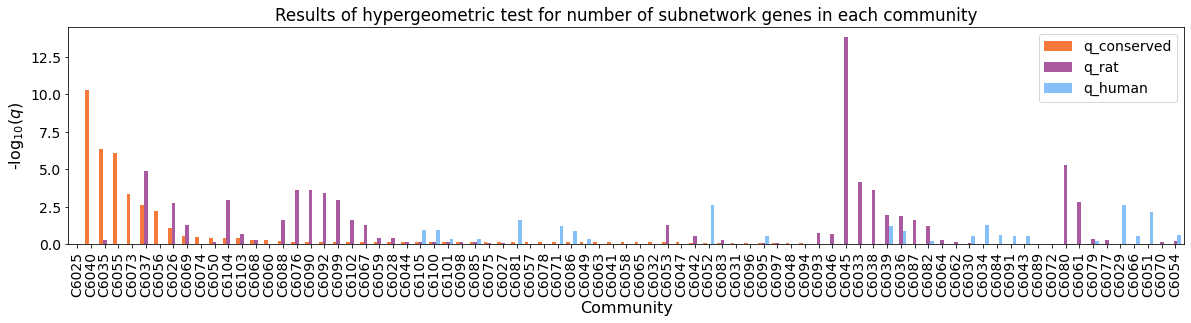

In [308]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
plot_data = all_hier_df.sort_values(by=["q_conserved", "q_rat", "q_human"]).loc[:, ("q_conserved", "q_rat", "q_human")]
(-1 * np.log10(plot_data)).plot.bar(ax=ax, width=0.8, color=["#f5793a", "#a95aa1", "#85c0f9"])
plt.xlabel("Community", fontsize=16)
_ = plt.ylabel("-log$_{10}(q)$", fontsize=16)
_ = plt.title("Results of hypergeometric test for number of subnetwork genes in each community")